# Harmonic Oscillator

To compute the solutions to the harmonic oscillator, we use our previous methods of constructng the Hamiltonian as a matrix, and then using the linear algebra of Numpy to find the eigen values and eigen vectors.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
hbar=1
m=1
omega=1
N = 2014
a = 20.0
x = np.linspace(-a/2.,a/2.,N)
h = x[1]-x[0] # Should be equal to 2*np.pi/(N-1)
V = .5*m*omega*x*x
# V[N/2]=2/h   # This would add a "delta" spike in the center.
Mdd = 1./(h*h)*(np.diag(np.ones(N-1),-1) -2* np.diag(np.ones(N),0) + np.diag(np.ones(N-1),1))
H = -(hbar*hbar)/(2.0*m)*Mdd + np.diag(V) 
En,psiT = np.linalg.eigh(H) # This computes the eigen values and eigenvectors
psi = np.transpose(psiT) 
# The psi now contain the wave functions ordered so that psi[n] if the n-th eigen state.

We want to verify that these resuls make sense, so we plot the wave functions and compute the norms. Note that the eigenvectors are normalized in such a way that $\sum psi_n^2(x_i) = 1$. This *does not* take into account the step size that we used for discretizing the space. We want to plot the wave functions in such a way that they plot the same independent of our choice of step size. To do this we need to divide the array of numbers by $\sqrt{\Delta x}$ before plotting.

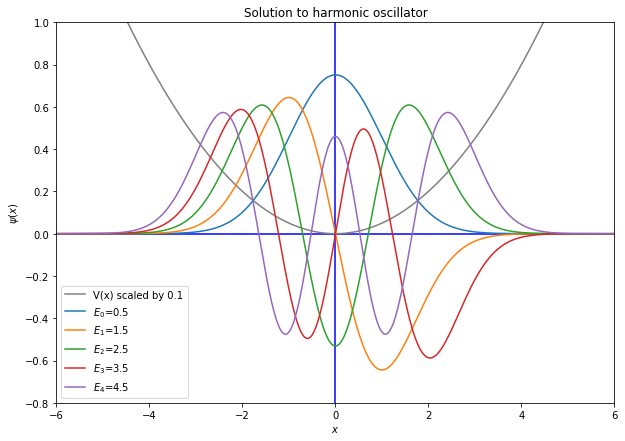

In [2]:
# Check the normalization of the wave function arrays.
for n in range(len(psi)):
    # s = np.sum(psi[n]*psi[n])
    s = np.linalg.norm(psi[n])
    if np.abs(s - 1) > 0.00001:
        print "Wave function {} is not normalized to 1 but {}".format(n,s)

fig2 = plt.figure(figsize=[10,7])
plt.title('Harmonic Oscillator')
plt.ylabel('$\psi(x)$')
plt.xlabel('$x$')
plt.plot([0,0],[-6,V[0]],color="blue")
plt.plot([-a/2.,a/2.],[0,0],color="blue")
plt.plot(x,0.1*V,color="grey",label="V(x) scaled by 0.1")
plt.ylim((-.8,1.))
plt.xlim((-6.,6.))
for i in range(0,5):
    if psi[i][N/8] < 0:
        plt.plot(x,-psi[i]/np.sqrt(h),label="$E_{}$={:3.1f}".format(i,En[i]))
    else:
        plt.plot(x,psi[i]/np.sqrt(h),label="$E_{}$={:3.1f}".format(i,En[i]))

plt.title("Solution to harmonic oscillator")
plt.legend()
plt.savefig("Harmonic_Oscillator_WaveFunctions.pdf")
plt.show()

We want to now plot the initial wave function. We could try to shift the already calculated $\psi_0(x)$ array, but it is better to compute the function from a formula. The *main reason* for making this plot is to make sure the *normalization* of the function is correct. We would want the *same normalization* as our $\psi_n(x)$ arrays, so we need to muliply the function by $\sqrt{\Delta x}$, which we then divide out again when we plot. Doing this makes sure that the $c_n$ factors we compute later are correct. 

Check the normalization of psi0:  1.0


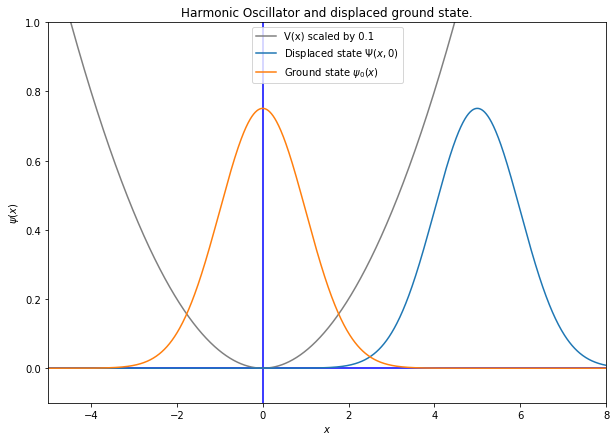

In [3]:
fig2 = plt.figure(figsize=[10,7])
plt.title('Harmonic Oscillator and displaced ground state.')
plt.ylabel('$\psi(x)$')
plt.xlabel('$x$')
plt.plot([0,0],[-6,V[0]],color="blue")
plt.plot([-a/2.,a/2.],[0,0],color="blue")
plt.plot(x,0.1*V,color="grey",label="V(x) scaled by 0.1")
plt.ylim((-.1,1.))
plt.xlim((-5.,8.))
a0=5.
alpha = (m*omega/(np.pi*hbar))**0.25
psi0 = np.sqrt(h)*alpha*np.exp(-(x-a0)**2*m*omega/(2*hbar))
n0 = np.linalg.norm(psi0)
print "Check the normalization of psi0: ",n0
plt.plot(x,psi0/np.sqrt(h),label="Displaced state $\Psi(x,0)$")
plt.plot(x,-psi[0]/np.sqrt(h),label="Ground state $\psi_0(x)$")
plt.legend()
plt.savefig("Displaced_state.pdf")
plt.show()

We can now compute the $c_n$ factors as a simple sum of the product of the initial wave and the $\psi_n(x)$ eigen states. There are many ways to accomplish this, looping over the $N$ eigen states. The way I do this below is particularly efficient, creating a new Numpy array of the $c_n$ factors. We can then sum the $c_n^2$ terms to make sure the normalization is indeed correct.

In [4]:
# cn=np.array([np.sum(psi[i]*psi0) for i in range(N)],dtype='float')
cn = psi.dot(psi0)
print cn[0:18]
print("Check sum: {:6.4f} -- Energy <E>={:8.5f}".format(np.sum(cn*cn),np.sum(np.conjugate(cn)*cn*En)))

[-0.00193046  0.00682502  0.01706212 -0.03482709  0.06156486  0.09734085
  0.14049748 -0.18774601  0.23468183  0.2765762  -0.30922498 -0.32964117
  0.33644786  0.32992637 -0.31176559 -0.28461787 -0.25158598  0.21575014]
Check sum: 1.0000 -- Energy <E>=13.00000


We now want to compute:
$$\Psi(x,t)=\sum_n c_n \psi_n(x) e^{-i(n+\frac{1}{2})\omega t}$$
For a particular time $t$ we thus want an array of numbers representing $\Psi$ at that time. A technical detail here is that we want to sum all the $n$ values for a particular $x_i$ of the product $c_n*\psi_n*\phi(t)$. Our wavefunctions are arranged in such a way that this would be a sum over the columns instead of over the rows (which is what we did when checking the normalization). We can circumvent this priblem by using the original transposed version of the wavefunction. Below are two different implementation of this function, the first one is a bit more straight forward, the second one is a bit faster (about a factor of 2.5).

In [5]:
# This version creates an array of zeros, to which it then sequentially adds each of the terms in the sum.
# Note that we use the global psi array.
def psi_xt(t,cn):
    out = np.zeros(N,dtype='complex128')
    for n in range(N): 
        out += cn[n]*psi[n]*np.exp(-1j*(n+0.5)*omega*t)
    return(out)

# This version uses np.sum to accomplish the same thing as the function above.
def psi_xt2(t,cn):
    n = np.arange(len(cn)) 
    times = np.exp(-1j*(n+0.5)*omega*t)
    out = psiT.dot(cn*times)
    return(out)

# This version uses np.sum and now also the previously calculated energyes.
# This way, psi_xt3 will work even if the potential is distorted and the energy levels are no longer (n+0.5)*hbar*omega
def psi_xt3(t,cn):
    out = psiT.dot(cn*np.exp(-1j*En*t/hbar))
    return(out)

We now compute the energy of this initial state, so we can plot the line on our graph. This was not part of the homework assignment, but it is nice to be able to draw this. We compute the energy as: $E=\sum |c_n|^2 E_n$. We also compute the energy as $E=\int \Psi^*(x,t=0)  \hat{\mathrm{H}} \Psi(x,t-0)$, and compare. 

In [7]:
E = np.sum(np.conjugate(cn)*cn*En)
print "<E> = {:9.4f}".format(E)
E_check = np.sum( np.conjugate(psi0)*H.dot(psi0)) 
print "Check E=",E_check

<E> =   13.0000
Check E= 12.9999969156


0.0
0.785398163397
1.57079632679
2.35619449019
3.14159265359


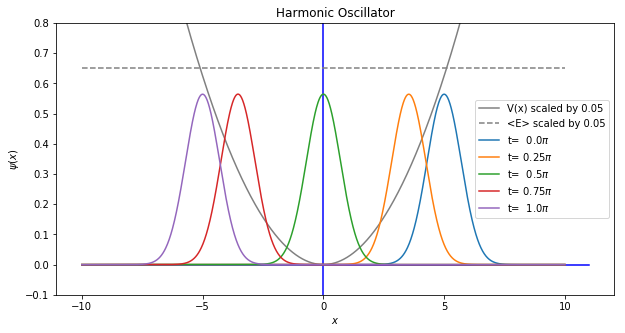

In [8]:
fig2 = plt.figure(figsize=[10,5])
plt.title('Harmonic Oscillator')
plt.ylabel('$\psi(x)$')
plt.xlabel('$x$')
plt.plot([0,0],[-6,V[0]],color="blue")
plt.plot([-a/2.,a/2.+1.],[0,0],color="blue")
plt.plot(x,0.05*V,color="grey",label="V(x) scaled by 0.05")
plt.plot([-a/2.,a/2.],[E*0.05,E*0.05],color="grey",linestyle="dashed",label="<E> scaled by 0.05")
plt.ylim((-.1,0.8))
# plt.plot(x,psi0/np.sqrt(h),color='#dddddd')
for t in [0.,np.pi/4.,np.pi/2.,3.*np.pi/4.,np.pi]: # np.linspace(0,np.pi,8):
    print t
    plt.plot(x,np.abs(psi_xt3(t,cn))**2/h,label="t={:5.3}$\pi$".format(t/np.pi))
plt.legend()
plt.savefig("Displaced_state_vs_time.pdf")
plt.show()

We can turn the restults into a little movie for a more dramatic effect. The 'animation' from matplotlib can do this for us. Since we run inside an HTML notebook, we need to render the movie into an html5 video for it to display.

The animation system wants an init() function that draws the frame, the axis, and everything else that does not change. The animate(t) function will then only draw the updated curve. To do this efficiently, we ask for the actual line object that is drawn for the plot, and then we only update the data for that line object.

In [9]:
import matplotlib.animation as animation
from IPython.display import HTML

fig3 = plt.figure(figsize=[10,7])
ax = fig3.add_subplot(111, autoscale_on=False, xlim=(-10, 10), ylim=(-0.1, 1.))
ax.grid()

line, = ax.plot([], [], lw=2,color='red')
time_template = 'time = {:9.2f}s'
time_text = ax.text(0.05, 0.93, '', transform=ax.transAxes)

def init():
    plt.title('Harmonic Oscillator')
    plt.ylabel('$\psi(x)$')
    plt.xlabel('$x$')
    plt.plot([0,0],[-6,V[0]],color="blue")
    plt.plot([-a/2.,a/2.],[0,0],color="blue")
    plt.plot(x,0.05*V,color="grey",label="V(x) scaled by 0.05")
    plt.plot([-a/2.,a/2.],[E*0.05,E*0.05],color="grey",linestyle="dashed",label="<E> scaled by 0.05")
    line.set_data([], [])
    time_text.set_text(time_template.format(0.))
    return line, time_text

def animate(t):
    #t = (float(i)/100.)*(4.*np.pi/omega)
    line.set_data(x,np.abs(psi_xt3(t,cn)/np.sqrt(h)))
    time_text.set_text(time_template.format(t))
    return line,  time_text


In [10]:
frame_rate = 30     # Frame rate in Hz. Make higher for smoother movie, but it takes longer to compute.
time_slowdown = 10  # Run time x times slower than normal. Since omega=1, we want this about 10.
ani = animation.FuncAnimation(fig3, animate, np.linspace(0,2*np.pi/omega,frame_rate*time_slowdown),
                              interval=1000./frame_rate, blit=True, init_func=init)
HTML(ani.to_html5_video())